In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
# import kagglehub
# kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
#
# icecube_neutrinos_in_deep_ice_path = kagglehub.competition_download('icecube-neutrinos-in-deep-ice')
#
# print('Data source import complete.')


In this work, I have employed a convolutional neural network architecture for the purpose of training a model. The input data for the network consists of a matrix of dimensions (5160 x 6), which comprises all the sensor readings. Each sensor reading is characterized by six distinct features, namely, x, y, z, time, charge, and auxiliary. These input features are fed into the network during the training process. Additionally, I am currently investigating methods for lossless input translation of coordinates. This [literature](https://arxiv.org/abs/2101.11589) suggests several promising approaches in this regard, which are being explored.

In [3]:
import os
import warnings
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import gc
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.filterwarnings("ignore", category=UserWarning, module='tensorflow')
import tensorflow as tf
from tqdm import tqdm

def angular_dist_score(az_true, zen_true, az_pred, zen_pred):
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)

    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    return np.average(np.abs(np.arccos(scalar_prod)))

def convert_to_cartesian(azimuth, zenith):
    x = np.sin(zenith) * np.cos(azimuth)
    y = np.sin(zenith) * np.sin(azimuth)
    z = np.cos(zenith)
    return x, y, z

def convert_to_polar(x, y, z):
    r = math.sqrt(x * x + y * y + z * z)
    c = -1 if y < 0 else 1
    azimuth = math.acos(x / math.sqrt(x * x + y * y)) * c
    zenith = math.acos(z / r)
    return azimuth, zenith

def adjust_polar(azimuth, zenith):
    if azimuth < 0:
        azimuth += math.pi * 2
    elif zenith < 0:
        zenith += math.pi
    return azimuth, zenith

E0000 00:00:1749494005.200051   44373 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749494005.203365   44373 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749494005.212169   44373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749494005.212180   44373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749494005.212181   44373 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749494005.212182   44373 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
path = "/home/washindeiru/primaryDrive/iceCube/icecube-neutrinos-in-deep-ice"

sensors_df = pd.read_csv(path + "/sensor_geometry.csv")
x_min, x_max, y_min, y_max, z_min, z_max = sensors_df.x.min(), sensors_df.x.max(), sensors_df.y.min(), sensors_df.y.max(), sensors_df.z.min(), sensors_df.z.max()
sensors_df['x'] = (sensors_df['x'] - x_min) / (x_max - x_min)
sensors_df['y'] = (sensors_df['y'] - y_min) / (y_max - y_min)
sensors_df['z'] = (sensors_df['z'] - z_min) / (z_max - z_min)
meta_df = pd.read_parquet(path + '/train_meta.parquet')
meta_df[['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index']] = meta_df[['batch_id', 'event_id', 'first_pulse_index', 'last_pulse_index']].astype(int)
meta_df[['azimuth', 'zenith']] = meta_df[['azimuth', 'zenith']].astype(np.float32)

df = pd.read_parquet(path + '/train_2/batch_1.parquet')
df['auxiliary'] = df['auxiliary'].astype(int)


In [5]:
sample_size = 5000

meta_batch_df = meta_df[meta_df.batch_id == 1]
meta_batch_df[['target_x', 'target_y', 'target_z']] = meta_batch_df[['azimuth', 'zenith']].apply(lambda x: convert_to_cartesian(x[0], x[1]), axis=1, result_type='expand')

matrix_main = np.zeros((sample_size, 5160, 6), dtype=np.float32)
target = np.zeros((sample_size, 3))

for indx in tqdm(range(0, sample_size, 1)):
    _, event_id, first_pulse_index, last_pulse_index, azimuth, zenith, target_x, target_y, target_z = meta_batch_df.iloc[indx].values
    df_study = df.iloc[int(first_pulse_index):int(last_pulse_index)].merge(sensors_df, on='sensor_id')
    minimum_time = df_study['time'].min()
    period = df_study['time'].max() - minimum_time
    df_study['time'] = (df_study['time'] - minimum_time) / (period)
    df_study.set_index('sensor_id', inplace=True)
    matrix = np.zeros((5160, 6))
    matrix[df_study.index.values, :] = df_study.values

    matrix_main[indx, :, :] = matrix
    target[indx, :] = target_x, target_y, target_z

del df, meta_df, sensors_df, meta_batch_df, df_study
gc.collect()

100%|██████████| 5000/5000 [00:04<00:00, 1052.10it/s]


0

In [6]:
train_p, validation_p = 0.92, 0.05

matrix_train = matrix_main[:int(sample_size * train_p), :, :]
target_train = target[:int(sample_size * train_p), :]

matrix_validation = matrix_main[int(sample_size * train_p):int(sample_size * (train_p + validation_p)), :, :]
target_validation = target[int(sample_size * train_p):int(sample_size * (train_p + validation_p)), :]

matrix_test = matrix_main[int(sample_size * (train_p + validation_p)):, :, :]
target_test = target[int(sample_size * (train_p + validation_p)):, :]

matrix_train.shape, target_train.shape, matrix_validation.shape, target_validation.shape, matrix_test.shape, target_test.shape

((4600, 5160, 6),
 (4600, 3),
 (250, 5160, 6),
 (250, 3),
 (150, 5160, 6),
 (150, 3))

In [7]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(128, (516, 6), activation='relu', input_shape=(5160, 6, 1)),
    tf.keras.layers.MaxPooling2D((2, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='linear')
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

I0000 00:00:1749494027.316961   44373 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5505 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


In [8]:
batch_size = 16
model.fit(matrix_train, target_train, epochs=3, batch_size=batch_size, validation_data=(matrix_validation, target_validation), callbacks=[early_stopping])

Epoch 1/3


I0000 00:00:1749494028.998847   44752 service.cc:152] XLA service 0x72b15801d970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749494028.998863   44752 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
I0000 00:00:1749494029.126089   44752 cuda_dnn.cc:529] Loaded cuDNN version 90701


  7/288 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.3880 - mae: 0.7819

I0000 00:00:1749494032.772222   44752 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


288/288 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.4172 - mae: 0.5216 - val_loss: 0.3330 - val_mae: 0.4961
Epoch 2/3
288/288 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.3331 - mae: 0.4983 - val_loss: 0.3329 - val_mae: 0.4962
Epoch 3/3
288/288 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.3330 - mae: 0.4995 - val_loss: 0.3326 - val_mae: 0.4959


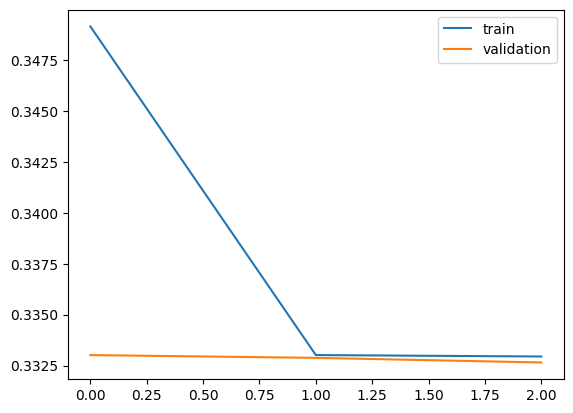

In [9]:
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [10]:
pred = model.predict(matrix_test)
pred_polar = np.array([convert_to_polar(x, y, z) for x, y, z in pred])
target_test_polar = np.array([convert_to_polar(x, y, z) for x, y, z in target_test])

az_true, zen_true = target_test_polar[:, 0], target_test_polar[:, 1]
az_pred, zen_pred = pred_polar[:, 0], pred_polar[:, 1]

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 339ms/step


In [11]:
angular_dist_score(az_true, zen_true, az_pred, zen_pred)

np.float64(1.5218011114534433)